In [173]:
import pandas as pd
from pathlib import Path
import html
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn import svm
import numpy as np

### Data pre-processing

In [174]:
'''Dataset Construction'''
# Parent directories, 'orginal' stores the original chapters translated by machine or by different translators; 
#                     'cleaned' stores the cleaned files by data pre-processing
ORIGINAL_DIR = Path('original')
CLEANED_DIR = Path('cleaned')

# Chuildren directories for each parent dir
PO_GOO_DIR = Path('po-en-goo') # stores chapters translated by Google Translate from the original version (Polish) of the book Solaris to English
PO_DL_DIR = Path('po-en-dl') # stores chapters translated by DeepL API from the original version (Polish) of the book Solaris to English
FR_GOO_DIR = Path('fr-en-goo') # stores chapters translated by Google Translate from the translated french version of the book Solaris to English
FR_DL_DIR = Path('fr-en-dl') # stores chapters translated by DeepL API from the translated french version of the book Solaris to English
EN1_DIR = Path('en1') # stores chapters of first translated version to English of the book Solaris
EN2_DIR = Path('en2') # stores chapters of second translated version to English of the book Solaris

# List to access children directories
DIRS = [PO_GOO_DIR, PO_DL_DIR, FR_GOO_DIR, FR_DL_DIR, EN1_DIR, EN2_DIR]

# List for all the translations
BOOKS = ['po-en-goo', 'po-en-dl', 'fr-en-goo', 'fr-en-dl', 'en1', 'en2']

In [175]:
# Find out the replacement by checking the vocabularies in parellel chapters for confirmation
TO_REPLACE = {
    'ö': 'o',
    'é': 'e',
    'ë': 'e',
    'ï': 'i',
    'ą': 'a',
    'í': 'i',
    'æ': 'ae',
    'ð': 'ny', # Original - fr-dl[8] 'caðon', changed to based on po-en-goo 'Canyon'
    'à': 'a',
    'å': 'a',
    'â': 'a',
    "'": '', # Replace apostrophe with nothing to protect contractions like don't -> dont
    '’': '',
    ' `': '',
}

In [176]:
# Function to check special characters by checking each translated texts.
allowed="abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789 \n"
def get_not_allowed(txt):
    others = set()
    for i in txt:
        if i not in allowed:
            others.add(i)
    return others

others = set()
for p in DIRS:
    for i in (ORIGINAL_DIR / p).iterdir(): # Checked by each directory contained target data
        with open(i) as f:
            txt = f.read()
            # Change the html punctuation format to the normal one
            txt = html.unescape(txt)
        others = others.union(get_not_allowed(txt))
print(others)

{'’', ')', '^', '(', '"', 'å', '?', '“', '–', 'ë', '_', "'", 'æ', ':', 'é', '`', ';', 'â', '!', '.', '-', 'ö', '•', 'ą', '‘', 'ï', 'ð', 'í', 'à', '»', '³', '\x0c', '…', '—', '”', ',', '*'}


In [177]:
'''Data Cleaning'''

for i in DIRS:
    for j in (ORIGINAL_DIR / i).iterdir():
        with open(j) as f:
            txt = f.read()
        
        # Change the html punctuation format to the normal one
        txt = html.unescape(txt)

        # Replace special characters
        for key in TO_REPLACE.keys():
            txt = txt.replace(key, TO_REPLACE[key])

        # Remove special characters
        for each in others:
            txt = txt.replace(each, ' ')
        
        # Lowercase everything
        txt = txt.lower()
        
        if not (CLEANED_DIR / i).is_dir():
            (CLEANED_DIR / i).mkdir(parents=True)

        with open(CLEANED_DIR / i / j.name, 'w') as f:
            f.write(txt)
            

### TF-IDF for the whole corpus

In [178]:
# a set of all the vocabularies in all documents
all_words = set()

for i in DIRS:
    for j in (CLEANED_DIR / i).iterdir():
        with open(j, "r") as f:
            wl = f.read().split()
            all_words = all_words.union(set(wl))
        
all_word_len = len(all_words) 


In [179]:
# Build empty dataframe to store the TF-IDFs from each document
df = pd.DataFrame(0, columns=list(all_words), index=[f"{b}-{i}" for b in BOOKS for i in range(1,15)])

for i in DIRS:
    for j in (CLEANED_DIR / i).iterdir():
        # Extract the number from the file's name (e.g. "po11.txt" -> "11")
        num = re.findall(r'\d+', j.stem)[-1]
        row = f"{i.stem}-{num}"
        with open(j, "r") as f:
            wl = f.read().split()
            for w in wl:
                df.loc[row, w] += 1



#### df2 = the tf-idf for each chapter

In [181]:
# Normalisation
df2 = df.div(df.sum(axis=1), axis=0)
df2.sum(axis=1)

df2

,cone,cycle,circuit,stirs,translates,offend,brimming,lids,prehistoric,boomed,...,effaced,merged,asynchronous,consumption,diffi,fatal,dire,boevi,slower,aide
po-en-goo-1,0.000313,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000313,...,0.000000,0.000000,0.000000,0.0,0.0,0.0000,0.0,0.0,0.0,0.0
po-en-goo-2,0.000000,0.0,0.000180,0.0,0.0,0.0,0.0,0.000180,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0000,0.0,0.0,0.0,0.0
po-en-goo-3,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0000,0.0,0.0,0.0,0.0
po-en-goo-4,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000399,...,0.000000,0.000000,0.000000,0.0,0.0,0.0002,0.0,0.0,0.0,0.0
po-en-goo-5,0.000000,0.0,0.000205,0.0,0.0,0.0,0.0,0.000205,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
en2-10,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0000,0.0,0.0,0.0,0.0
en2-11,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0000,0.0,0.0,0.0,0.0
en2-12,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000248,0.0,0.000000,...,0.000000,0.000248,0.000000,0.0,0.0,0.0000,0.0,0.0,0.0,0.0
en2-13,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000355,0.0,0.0,0.0000,0.0,0.0,0.0,0.0


#### df4 is the tf-idf for each book

In [182]:
df3 = df2.T
df3['po-en-goo'] = df3.loc[:,df3.columns.str.startswith('po-en-goo-')].sum(axis=1)
df3['po-en-dl'] = df3.loc[:,df3.columns.str.startswith('po-en-dl-')].sum(axis=1)
df3['fr-en-goo'] = df3.loc[:,df3.columns.str.startswith('fr-en-goo-')].sum(axis=1)
df3['fr-en-dl'] = df3.loc[:,df3.columns.str.startswith('fr-en-dl-')].sum(axis=1)
df3['en1'] = df3.loc[:,df3.columns.str.startswith('en1-')].sum(axis=1)
df3['en2'] = df3.loc[:,df3.columns.str.startswith('en2-')].sum(axis=1)
df3 = df3/14

# df4 is the tf-idf for each book
df4 = df3.iloc[:,-6:]
df4 = df4.T
df4

,cone,cycle,circuit,stirs,translates,offend,brimming,lids,prehistoric,boomed,...,effaced,merged,asynchronous,consumption,diffi,fatal,dire,boevi,slower,aide
po-en-goo,0.000042,0.000012,0.000036,0.000000,0.000000,0.000030,0.000000,0.000047,0.000012,0.000051,...,0.000000,0.000040,0.000029,0.000000,0.000000,0.000022,0.000000,0.000000,0.000056,0.000000
po-en-dl,0.000040,0.000000,0.000021,0.000000,0.000000,0.000019,0.000000,0.000052,0.000011,0.000028,...,0.000000,0.000052,0.000027,0.000000,0.000000,0.000021,0.000000,0.000012,0.000051,0.000000
fr-en-goo,0.000043,0.000000,0.000038,0.000000,0.000012,0.000000,0.000000,0.000026,0.000012,0.000000,...,0.000000,0.000035,0.000028,0.000012,0.000000,0.000014,0.000000,0.000000,0.000000,0.000012
fr-en-dl,0.000043,0.000000,0.000037,0.000009,0.000000,0.000000,0.000000,0.000041,0.000012,0.000000,...,0.000000,0.000035,0.000028,0.000000,0.000000,0.000014,0.000000,0.000000,0.000000,0.000012
en1,0.000051,0.000000,0.000064,0.000020,0.000000,0.000021,0.000012,0.000068,0.000012,0.000000,...,0.000000,0.000018,0.000029,0.000000,0.000000,0.000015,0.000000,0.000000,0.000000,0.000000
en2,0.000038,0.000013,0.000021,0.000007,0.000000,0.000000,0.000000,0.000029,0.000000,0.000000,...,0.000018,0.000058,0.000025,0.000000,0.000013,0.000000,0.000013,0.000000,0.000013,0.000000


In [183]:
# Check nomalisation
df4.sum(axis=1)

po-en-goo    1.0
po-en-dl     1.0
fr-en-goo    1.0
fr-en-dl     1.0
en1          1.0
en2          1.0
dtype: float64

### Data Analysis via principal component analysis

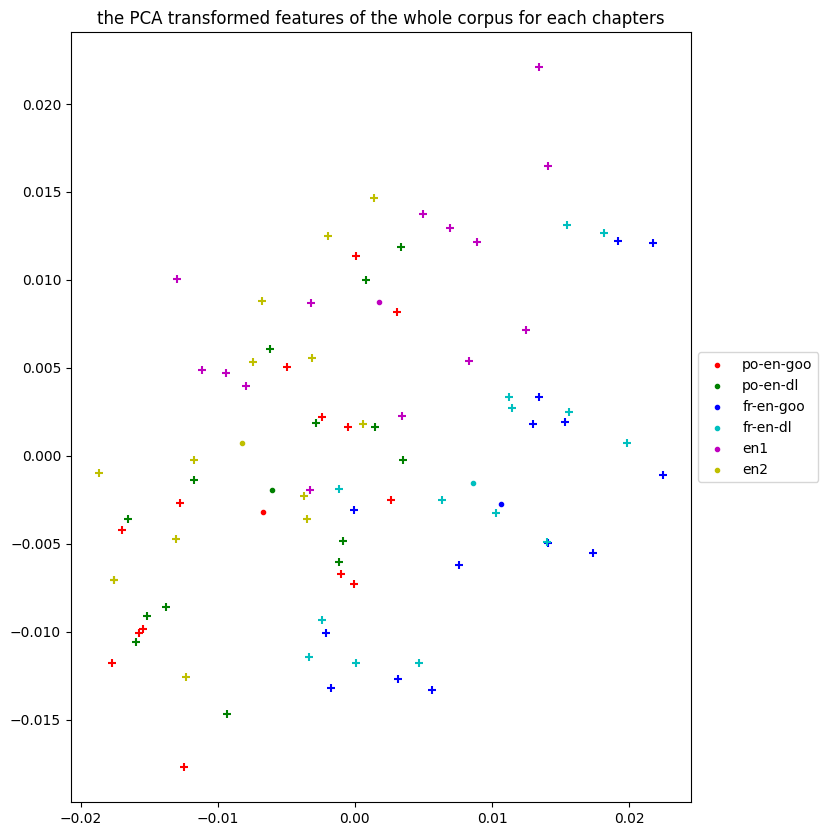

In [265]:
'''Plotting the pca features for each chapter and each book'''
# Applies principal component analysis
pca = PCA(n_components=2)
pca_doc = pca.fit_transform(df4)
pca_chp = pca.transform(df2)

# COLOUR_MAP = "tab10"
# CMAP = plt.get_cmap(COLOUR_MAP)
# rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))

# colours = [CMAP(i) for i in rescale(np.arange(6))]
colours = ['r','g','b','c','m','y']
# plt.style.use('ggplot')
ax = plt.subplot(111)
for i in range(6):
    ax.scatter(pca_doc[i,0], pca_doc[i,1], color=colours[i], marker='.', label=BOOKS[i])
    ax.scatter(pca_chp[14*i:14*(i+1),0], pca_chp[14*i:14*(i+1),1], color=colours[i], marker='+')

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.set_title('the PCA transformed features of the whole corpus for each chapters')
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

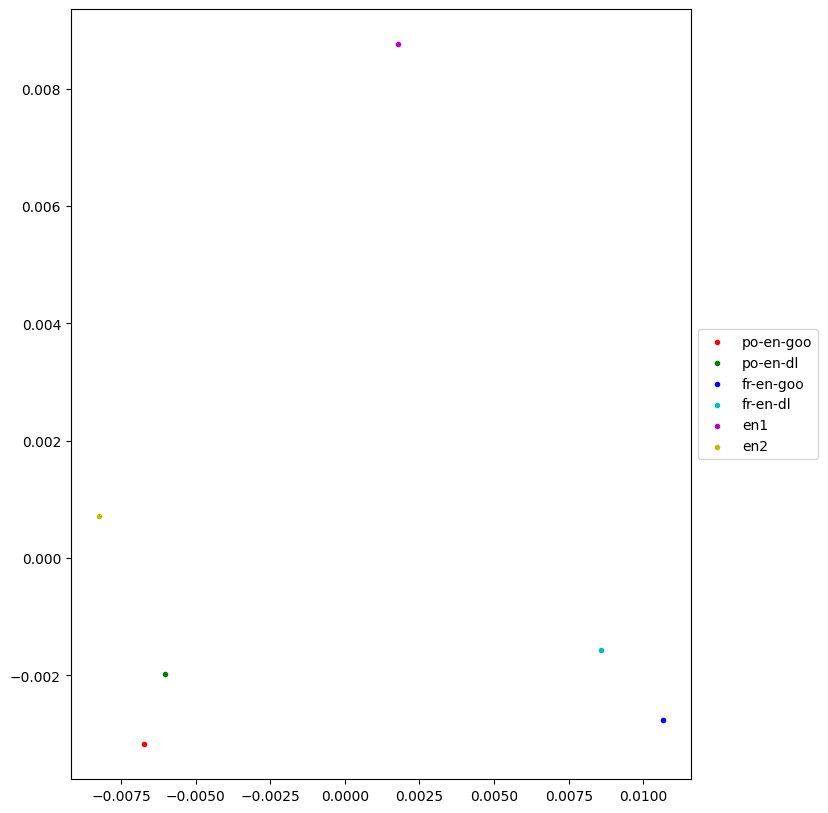

In [187]:
colours = ['r','g','b','c','m','y']
ax = plt.subplot(111)
for i in range(6):
    ax.scatter(pca_doc[i,0], pca_doc[i,1], color=colours[i], marker='.', label=BOOKS[i])

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

In [188]:
# Function word corpus is from https://www.edu.uwo.ca/faculty-profiles/docs/other/webb/essential-word-list.pdf
with open('function-words.txt') as f:
    fct_w = f.read().split()

fct_w


['the',
 'which',
 'still',
 'although',
 'forty',
 'and',
 'up',
 'last',
 'past',
 'nobody',
 'of',
 'out',
 'being',
 'himself',
 'unless',
 'to',
 'would',
 'must',
 'seven',
 'mine',
 'a',
 'when',
 'another',
 'eight',
 'anybody',
 'i',
 'your',
 'between',
 'along',
 'till',
 'in',
 'will',
 'might',
 'round',
 'herself',
 'you',
 'their',
 'both',
 'several',
 'twelve',
 'that',
 'who',
 'five',
 'someone',
 'fifteen',
 'it',
 'some',
 'four',
 'whatever',
 'beyond',
 'for',
 'two',
 'around',
 'among',
 'whom',
 'he',
 'because',
 'while',
 'across',
 'below',
 'on',
 'how',
 'each',
 'behind',
 'none',
 'we',
 'other',
 'under',
 'million',
 'nor',
 'they',
 'could',
 'away',
 'outside',
 'more',
 'be',
 'our',
 'every',
 'nine',
 'most',
 'with',
 'into',
 'next',
 'thousand',
 'this',
 'these',
 'anything',
 'shall',
 'have',
 'than',
 'few',
 'myself',
 'but',
 'any',
 'though',
 'themselves',
 'as',
 'where',
 'since',
 'itself',
 'not',
 'over',
 'against',
 'somebody',


In [189]:
df5 = df4[fct_w]

df5

,the,which,still,although,forty,and,up,last,past,nobody,...,ten,anyone,my,off,twenty,per,her,through,either,except
po-en-goo,0.058397,0.002176,0.001451,0.000257,0.000134,0.021127,0.003096,0.000833,0.000146,0.000043,...,0.000220,0.000257,0.007997,0.000929,0.000166,0.000008,0.006256,0.001331,0.000237,0.000163
po-en-dl,0.058931,0.002457,0.001643,0.000335,0.000135,0.020056,0.003380,0.000696,0.000114,0.000083,...,0.000197,0.000259,0.008298,0.001006,0.000192,0.000057,0.005990,0.001198,0.000216,0.000142
fr-en-goo,0.067304,0.003955,0.000775,0.000160,0.000210,0.019353,0.003820,0.000689,0.000097,0.000090,...,0.000203,0.000237,0.009650,0.000626,0.000174,0.000044,0.004193,0.000898,0.000170,0.000109
fr-en-dl,0.066515,0.003192,0.000938,0.000132,0.000201,0.021096,0.003696,0.000854,0.000153,0.000019,...,0.000185,0.000271,0.009880,0.000766,0.000185,0.000024,0.004940,0.000995,0.000195,0.000074
en1,0.061532,0.003923,0.001435,0.000323,0.000107,0.024265,0.003519,0.000639,0.000188,0.000077,...,0.000177,0.000171,0.010049,0.001072,0.000146,0.000035,0.006039,0.001414,0.000216,0.000250
en2,0.057829,0.002442,0.001488,0.000000,0.000121,0.018617,0.003908,0.000530,0.000124,0.000034,...,0.000218,0.000260,0.008700,0.001389,0.000185,0.000036,0.006936,0.001346,0.000345,0.000170


In [190]:
# Applies principal component analysis
pca = PCA(n_components=2)
pca_fnc = pca.fit_transform(df5)

In [191]:
pca_fnc.shape

(6, 2)

In [192]:
tmp = pca.components_.T
x = tmp-tmp.mean(axis=0)

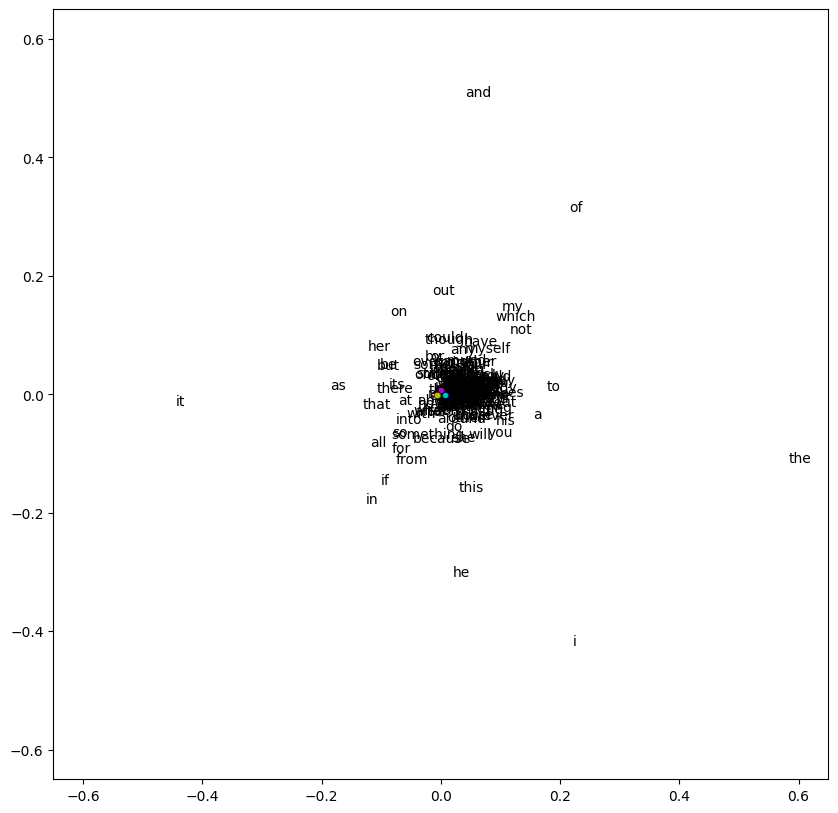

In [193]:
plt.rcParams["figure.figsize"] = (10,10)
colours = ['r','g','b','c','m','y']

for i in range(176):
    plt.text(x[i,0], x[i,1], fct_w[i], zorder=0)

for i in range(6):
    plt.scatter(pca_fnc[i,0], pca_fnc[i,1], color=colours[i], marker='.', label=BOOKS[i], zorder=20)

plt.xlim([-0.65,0.65])
plt.ylim([-0.65,0.65])
plt.show()

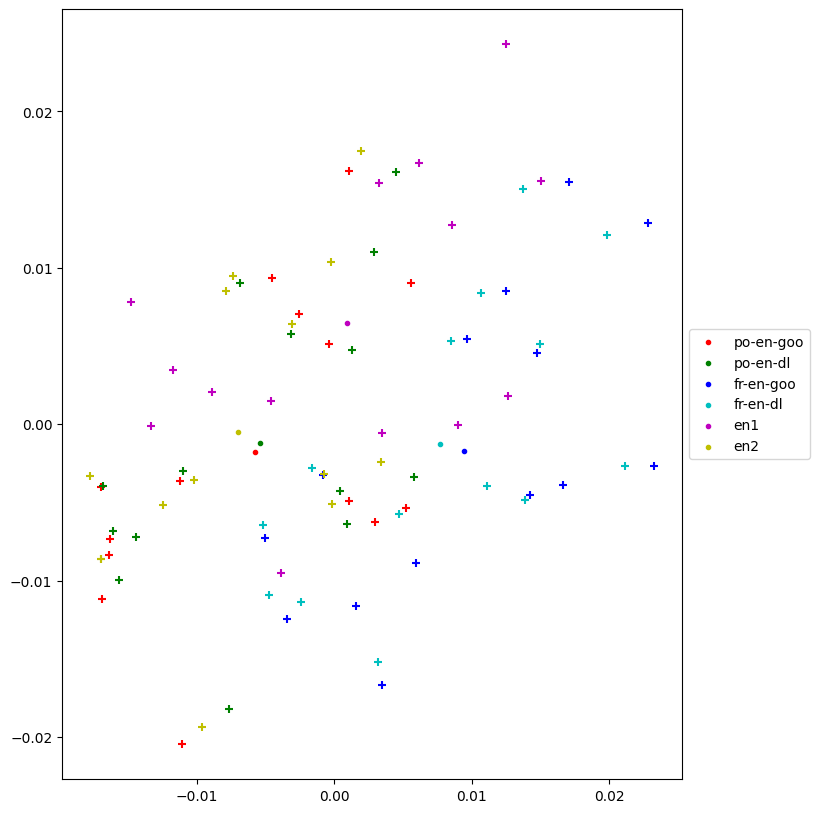

In [194]:
df6 = df2[fct_w]
# Applies principal component analysis
pca = PCA(n_components=2)
pca_fnc_doc = pca.fit_transform(df5)
pca_fnc_chp = pca.transform(df6)

# Plat function words based on chapters and books
colours = ['r','g','b','c','m','y']
ax = plt.subplot(111)
for i in range(6):
    ax.scatter(pca_fnc_doc[i,0], pca_fnc_doc[i,1], color=colours[i], marker='.', label=BOOKS[i])
    ax.scatter(pca_fnc_chp[14*i:14*(i+1),0], pca_fnc_chp[14*i:14*(i+1),1], color=colours[i], marker='+')

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

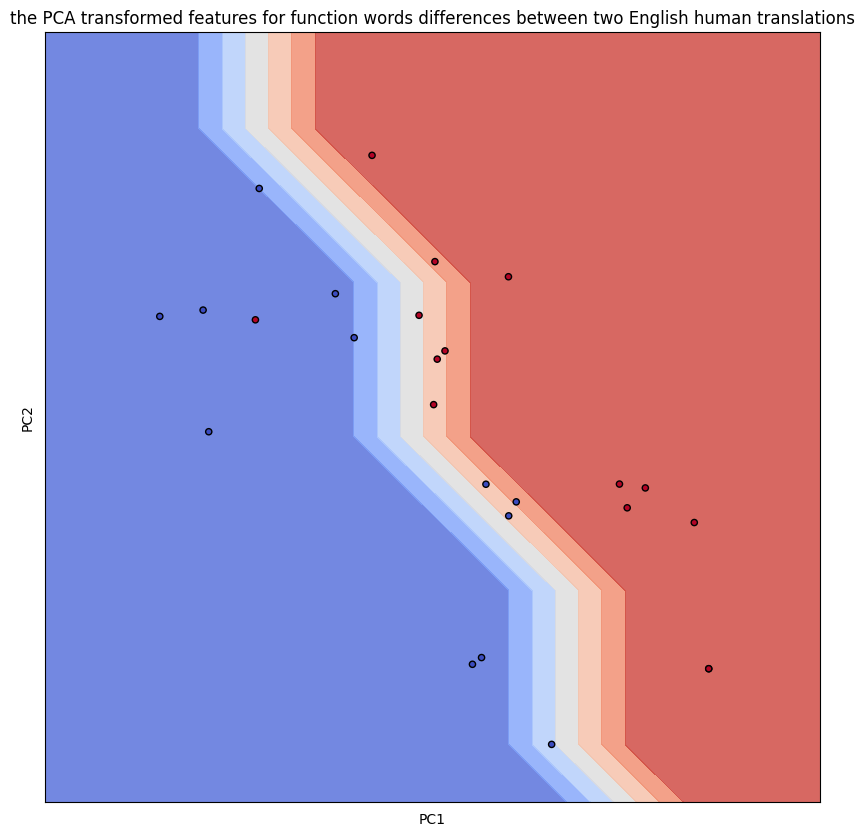

In [195]:
'''Analyse the difference between the orginal two English translations by function words '''
# Construct data
df_en_doc = df3.loc[:, ['en1', 'en2']].T
df_en_chp = df3.loc[:,df3.columns.str.startswith('en')]
df_en_chp = df_en_chp.iloc[:,:-2].T

# Normalised data
df_en_doc = df_en_doc[fct_w].div(df_en_doc[fct_w].sum(axis=1),axis=0)
df_en_chp = df_en_chp[fct_w].div(df_en_chp[fct_w].sum(axis=1),axis=0)

# Checking whether the normalisation is sucessful
# print(df_en_doc[fct_w].div(df_en_doc[fct_w].sum(axis=1),axis=0).sum(axis=1))

# Applies principal component analysis
pca = PCA(n_components=2)
en_doc = pca.fit_transform(df_en_doc)
en_chp = pca.transform(df_en_chp)

# Skeloton code for plotting taken from:
# https://stackoverflow.com/a/51301399
def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

y = [0]*14 + [1]*14

model = svm.SVC(kernel='poly')
clf = model.fit(en_chp, y)

fig, ax = plt.subplots()
# title for the plots
title = ('Decision surface of linear SVC ')
# Set-up grid for plotting.
X0, X1 = en_chp[:, 0], en_chp[:, 1]
xx, yy = make_meshgrid(X0, X1)

plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
ax.set_ylabel('PC2')
ax.set_xlabel('PC1')
ax.set_xticks(())
ax.set_yticks(())
ax.set_title('the PCA transformed features for function words differences between two English human translations')

ax.set_xlim([-0.05,0.05])
ax.set_ylim([-0.05,0.05])
plt.show()

In [196]:
acurracy_en = (model.predict(en_chp) == np.array(y)).sum() / 28
acurracy_en

0.8214285714285714

In [197]:
clf = svm.SVC()
X = df_en_chp.iloc[list(range(10)) + list(range(14,24)), :]
test_X = df_en_chp.iloc[list(range(10,14)) + list(range(24,28)), :]
clf.fit(X, [0]*10 + [1]*10)
clf.predict(test_X)

array([0, 0, 1, 0, 0, 1, 1, 0])

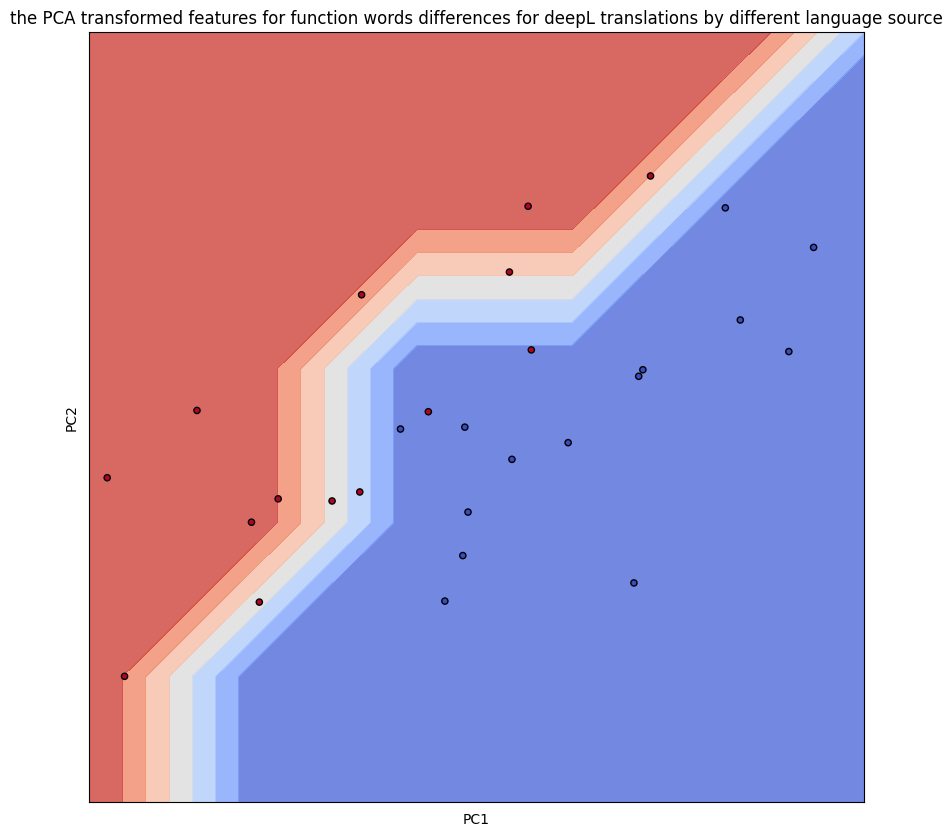

In [217]:
'''Analyse the difference between DeepL translation from different language source by function words '''
'''DeepL translation of france and polish to english'''
'''Question: Will there be a style for a machine translator (DeepL)?'''
# Data construction
df_fpd_doc = df3.loc[fct_w, ['po-en-dl', 'fr-en-dl']].T
cols = [f"po-en-dl-{i}" for i in range(1,15)] + [f"fr-en-dl-{i}" for i in range(1,15)]
df_fpd_chp = df3.loc[fct_w,cols].T

# Normalised data
df_fpd_doc = df_fpd_doc.div(df_fpd_doc.sum(axis=1),axis=0)
df_fpd_chp = df_fpd_chp.div(df_fpd_chp.sum(axis=1),axis=0)

# Checking whether the normalisation is sucessful
# print(df_frd_doc[fct_w].div(df_frd_doc[fct_w].sum(axis=1),axis=0).sum(axis=1))

# Applies principal component analysis
pca = PCA(n_components=2)
fpd_doc = pca.fit_transform(df_fpd_doc)
fpd_chp = pca.transform(df_fpd_chp)

# Skeloton code for plotting taken from:
# https://stackoverflow.com/a/51301399
def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

y = [0]*14 + [1]*14

model = svm.SVC(kernel='poly')
clf = model.fit(fpd_chp, y)

fig, ax = plt.subplots()
# title for the plots
title = ('Decision surface of linear SVC ')
# Set-up grid for plotting.
X0, X1 = fpd_chp[:, 0], fpd_chp[:, 1]
xx, yy = make_meshgrid(X0, X1)

plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
ax.set_ylabel('PC2')
ax.set_xlabel('PC1')
ax.set_xticks(())
ax.set_yticks(())
ax.set_title('the PCA transformed features for function words differences for deepL translations by different language source')

ax.set_xlim([-0.05,0.05])
ax.set_ylim([-0.05,0.05])
plt.show()


In [218]:
acurracy_fp_deepl = (model.predict(fpd_chp) == np.array(y)).sum() / 28
acurracy_fp_deepl

0.9285714285714286

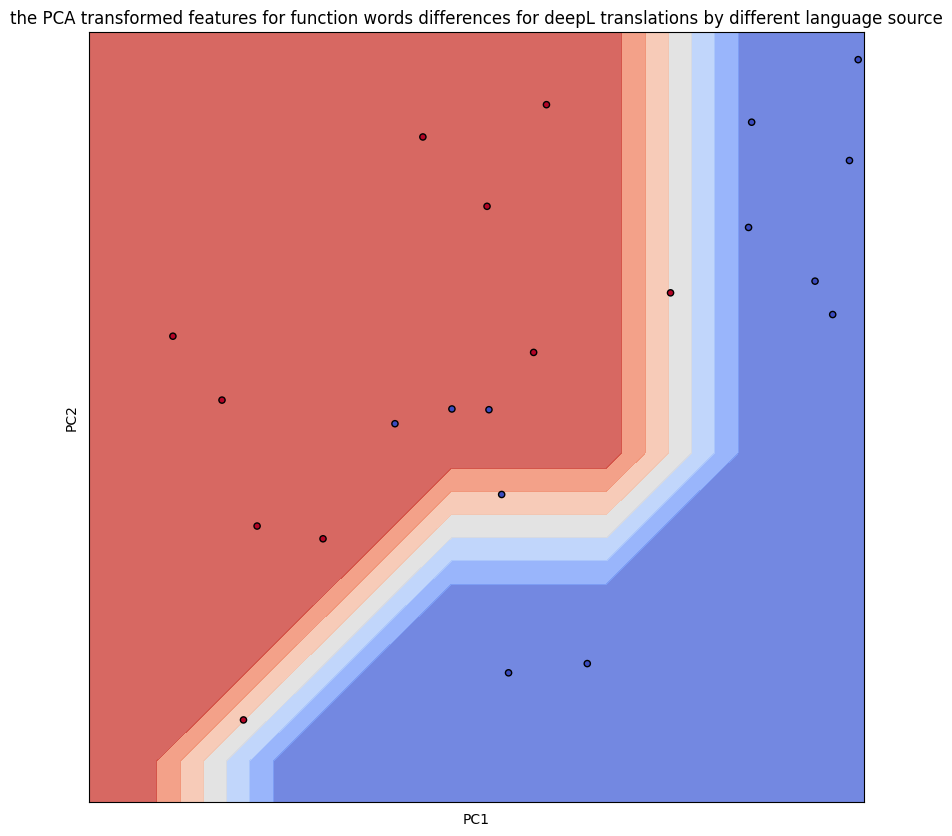

In [219]:
'''Analyse the difference between Goggle translation from different language source by function words '''
'''translation from france and polish to english'''
'''Question: Will there be a style for a machine translator (Google)?'''
# Data construction
df_fpg_doc = df3.loc[fct_w, ['po-en-goo', 'fr-en-goo']].T
cols = [f"po-en-goo-{i}" for i in range(1,15)] + [f"fr-en-goo-{i}" for i in range(1,15)]
df_fpg_chp = df3.loc[fct_w,cols].T

# Normalised data
df_fpg_doc = df_fpg_doc.div(df_fpg_doc.sum(axis=1),axis=0)
df_fpg_chp = df_fpg_chp.div(df_fpg_chp.sum(axis=1),axis=0)

# Checking whether the normalisation is sucessful
# print(df_frd_doc[fct_w].div(df_frd_doc[fct_w].sum(axis=1),axis=0).sum(axis=1))

# Applies principal component analysis
pca = PCA(n_components=2)
fpg_doc = pca.fit_transform(df_fpg_doc)
fpg_chp = pca.transform(df_fpg_chp)

# Skeloton code for plotting taken from:
# https://stackoverflow.com/a/51301399
def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

y = [0]*14 + [1]*14

model = svm.SVC(kernel='poly')
clf = model.fit(fpg_chp, y)

fig, ax = plt.subplots()
# title for the plots
title = ('Decision surface of linear SVC ')
# Set-up grid for plotting.
X0, X1 = fpg_chp[:, 0], fpg_chp[:, 1]
xx, yy = make_meshgrid(X0, X1)

plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
ax.set_ylabel('PC2')
ax.set_xlabel('PC1')
ax.set_xticks(())
ax.set_yticks(())
ax.set_title('the PCA transformed features for function words differences for Google translations by different language source')

ax.set_xlim([-0.05,0.05])
ax.set_ylim([-0.05,0.05])
plt.show()


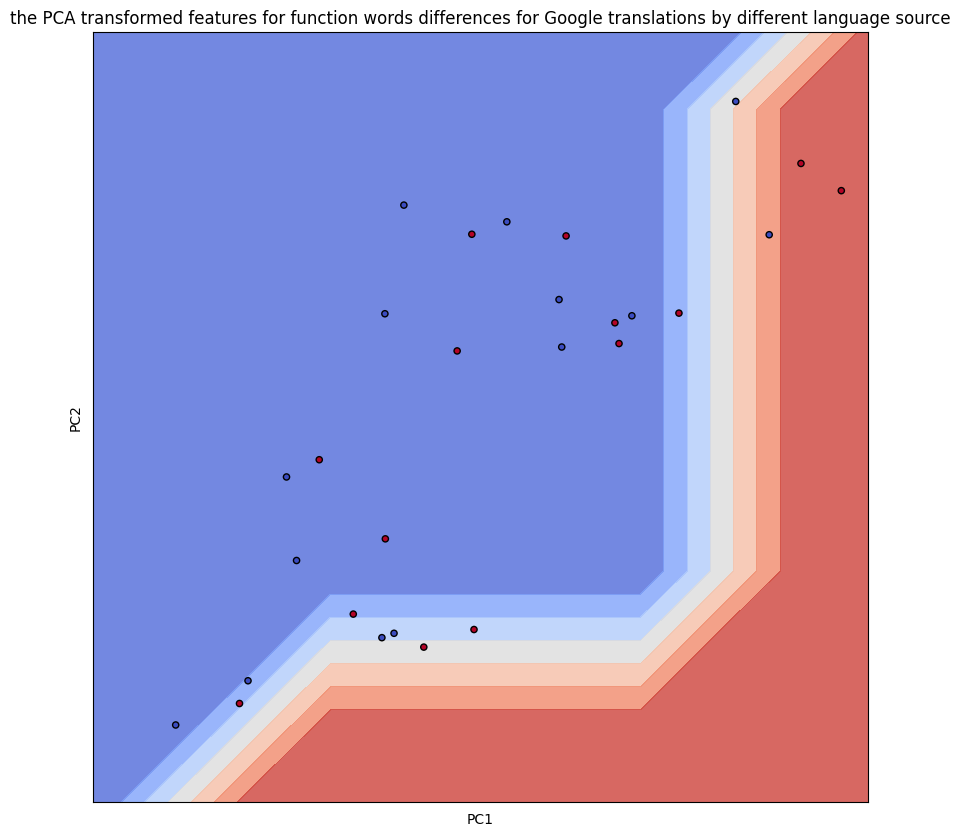

In [221]:
'''Analyse the difference between  Google and DeepL by function words '''
'''translation from Polish to English'''
'''Question: Will there the style be explicitly different by different machine translation?'''
# Data construction
df_pem_doc = df3.loc[fct_w, ['po-en-goo', 'po-en-dl']].T
cols = [f"po-en-goo-{i}" for i in range(1,15)] + [f"po-en-dl-{i}" for i in range(1,15)]
df_pem_chp = df3.loc[fct_w,cols].T

# Normalised data
df_pem_doc = df_pem_doc.div(df_pem_doc.sum(axis=1),axis=0)
df_pem_chp = df_pem_chp.div(df_pem_chp.sum(axis=1),axis=0)

# Checking whether the normalisation is sucessful
# print(df_frd_doc[fct_w].div(df_frd_doc[fct_w].sum(axis=1),axis=0).sum(axis=1))

# Applies principal component analysis
pca = PCA(n_components=2)
pem_doc = pca.fit_transform(df_pem_doc)
pem_chp = pca.transform(df_pem_chp)

# Skeloton code for plotting taken from:
# https://stackoverflow.com/a/51301399
def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

y = [0]*14 + [1]*14

model = svm.SVC(kernel='poly')
clf = model.fit(pem_chp, y)

fig, ax = plt.subplots()
# title for the plots
title = ('Decision surface of linear SVC ')
# Set-up grid for plotting.
X0, X1 = pem_chp[:, 0], pem_chp[:, 1]
xx, yy = make_meshgrid(X0, X1)

plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
ax.set_ylabel('PC2')
ax.set_xlabel('PC1')
ax.set_xticks(())
ax.set_yticks(())
ax.set_title('the PCA transformed features for function words differences for Google and DeepL translation 1')

ax.set_xlim([-0.05,0.05])
ax.set_ylim([-0.05,0.05])
plt.show()


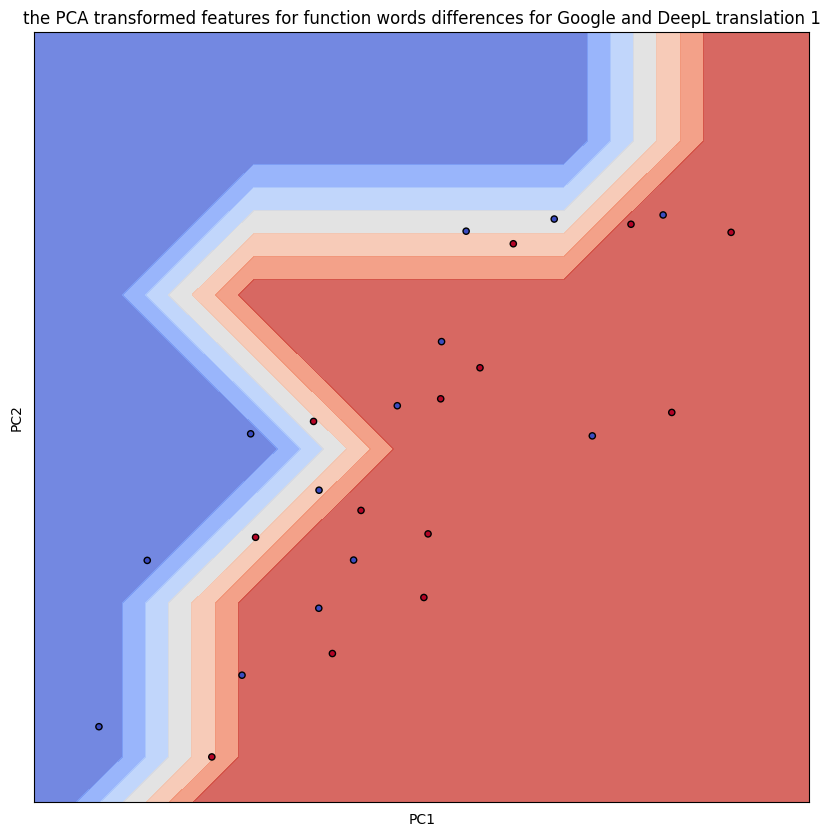

In [223]:
'''Analyse the difference between  Google and DeepL by function words '''
'''translation from French to English'''
'''Question: Will there the style be explicitly different by different machine translation?'''
# Data construction
df_fem_doc = df3.loc[fct_w, ['fr-en-goo', 'fr-en-dl']].T
cols = [f"fr-en-goo-{i}" for i in range(1,15)] + [f"fr-en-dl-{i}" for i in range(1,15)]
df_fem_chp = df3.loc[fct_w,cols].T

# Normalised data
df_fem_doc = df_fem_doc.div(df_fem_doc.sum(axis=1),axis=0)
df_fem_chp = df_fem_chp.div(df_fem_chp.sum(axis=1),axis=0)

# Checking whether the normalisation is sucessful
# print(df_frd_doc[fct_w].div(df_frd_doc[fct_w].sum(axis=1),axis=0).sum(axis=1))

# Applies principal component analysis
pca = PCA(n_components=2)
fem_doc = pca.fit_transform(df_fem_doc)
fem_chp = pca.transform(df_fem_chp)

# Skeloton code for plotting taken from:
# https://stackoverflow.com/a/51301399
def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

y = [0]*14 + [1]*14

model = svm.SVC(kernel='poly')
clf = model.fit(fem_chp, y)

fig, ax = plt.subplots()
# title for the plots
title = ('Decision surface of linear SVC ')
# Set-up grid for plotting.
X0, X1 = fem_chp[:, 0], fem_chp[:, 1]
xx, yy = make_meshgrid(X0, X1)

plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
ax.set_ylabel('PC2')
ax.set_xlabel('PC1')
ax.set_xticks(())
ax.set_yticks(())
ax.set_title('the PCA transformed features for function words differences for Google and DeepL translation 1')

ax.set_xlim([-0.05,0.05])
ax.set_ylim([-0.05,0.05])
plt.show()


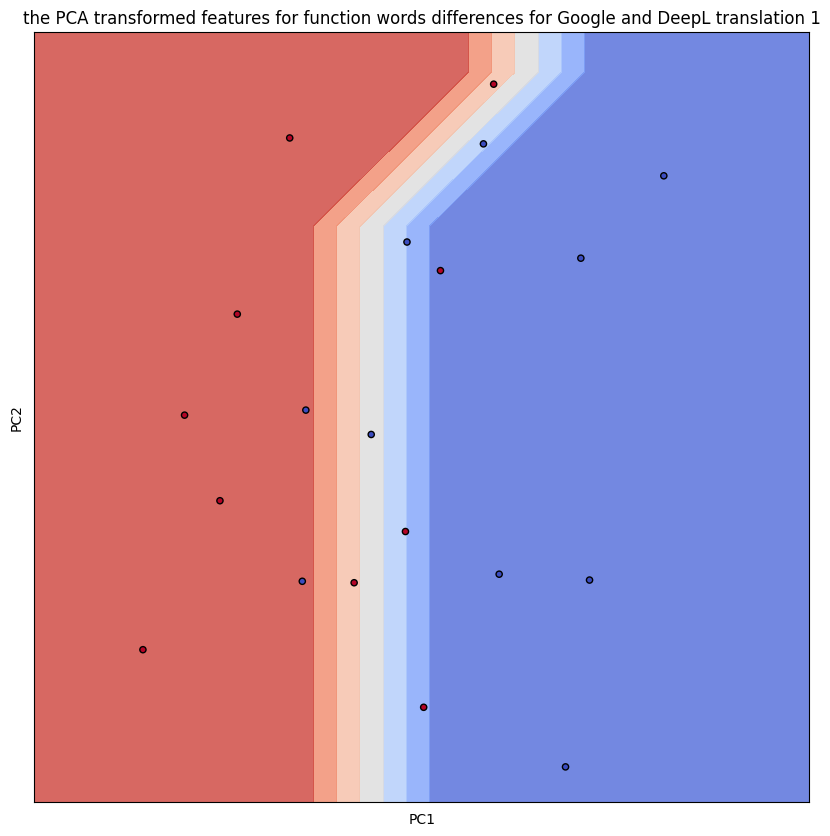

In [227]:
'''Analyse the difference between human and DeepL by function words '''
'''translation from French to English'''
'''Question: Will there the style be explicitly different by different machine translation?'''
# Data construction
df_fhm_doc = df3.loc[fct_w, ['en1', 'fr-en-dl']].T
cols = [f"en1-{i}" for i in range(1,15)] + [f"fr-en-dl-{i}" for i in range(1,15)]
df_fhm_chp = df3.loc[fct_w,cols].T

# Normalised data
df_fhm_doc = df_fhm_doc.div(df_fhm_doc.sum(axis=1),axis=0)
df_fhm_chp = df_fhm_chp.div(df_fhm_chp.sum(axis=1),axis=0)

# Checking whether the normalisation is sucessful
# print(df_frd_doc[fct_w].div(df_frd_doc[fct_w].sum(axis=1),axis=0).sum(axis=1))

# Applies principal component analysis
pca = PCA(n_components=2)
fhm_doc = pca.fit_transform(df_fhm_doc)
fhm_chp = pca.transform(df_fhm_chp)

# Skeloton code for plotting taken from:
# https://stackoverflow.com/a/51301399
def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

y = [0]*14 + [1]*14

model = svm.SVC(kernel='rbf')
clf = model.fit(fhm_chp, y)

fig, ax = plt.subplots()
# title for the plots
title = ('Decision surface of linear SVC ')
# Set-up grid for plotting.
X0, X1 = fhm_chp[:, 0], fhm_chp[:, 1]
xx, yy = make_meshgrid(X0, X1)

plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
ax.set_ylabel('PC2')
ax.set_xlabel('PC1')
ax.set_xticks(())
ax.set_yticks(())
ax.set_title('the PCA transformed features for function words differences for human and DeepL translation 1')

ax.set_xlim([-0.05,0.05])
ax.set_ylim([-0.05,0.05])
plt.show()


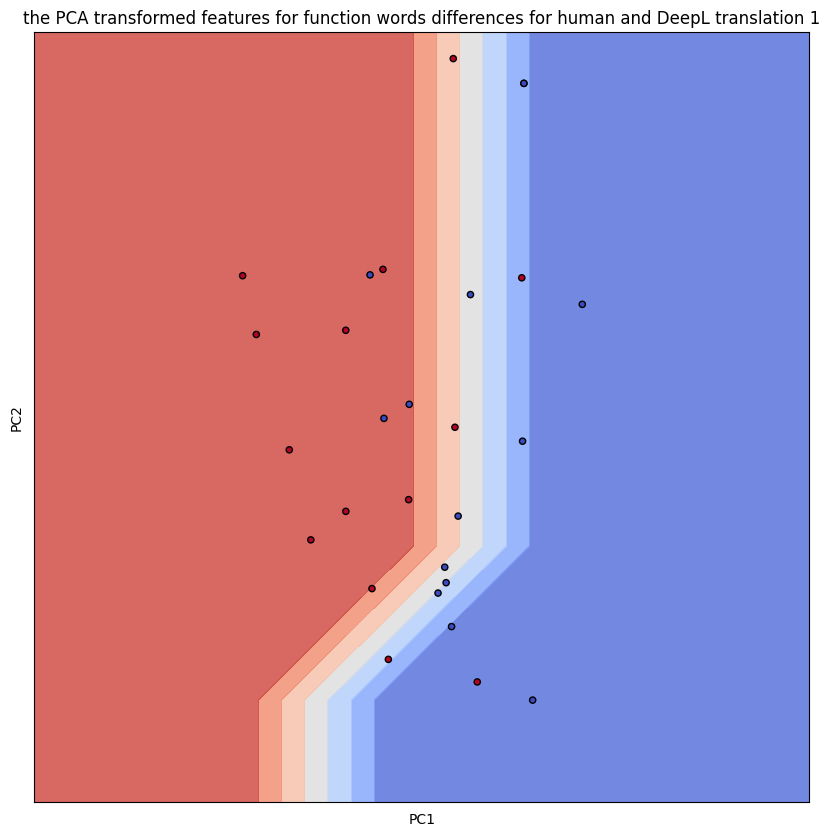

In [230]:
'''Analyse the difference between human and DeepL by function words '''
'''translation from French to English'''
'''Question: Will there the style be explicitly different by different machine translation?'''
# Data construction
df_phm_doc = df3.loc[fct_w, ['en2', 'po-en-dl']].T
cols = [f"en2-{i}" for i in range(1,15)] + [f"po-en-dl-{i}" for i in range(1,15)]
df_phm_chp = df3.loc[fct_w,cols].T

# Normalised data
df_phm_doc = df_phm_doc.div(df_phm_doc.sum(axis=1),axis=0)
df_phm_chp = df_phm_chp.div(df_phm_chp.sum(axis=1),axis=0)

# Checking whether the normalisation is sucessful
# print(df_frd_doc[fct_w].div(df_frd_doc[fct_w].sum(axis=1),axis=0).sum(axis=1))

# Applies principal component analysis
pca = PCA(n_components=2)
phm_doc = pca.fit_transform(df_phm_doc)
phm_chp = pca.transform(df_phm_chp)

# Skeloton code for plotting taken from:
# https://stackoverflow.com/a/51301399
def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

y = [0]*14 + [1]*14

model = svm.SVC(kernel='poly')
clf = model.fit(phm_chp, y)

fig, ax = plt.subplots()
# title for the plots
title = ('Decision surface of linear SVC ')
# Set-up grid for plotting.
X0, X1 = phm_chp[:, 0], phm_chp[:, 1]
xx, yy = make_meshgrid(X0, X1)

plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
ax.set_ylabel('PC2')
ax.set_xlabel('PC1')
ax.set_xticks(())
ax.set_yticks(())
ax.set_title('the PCA transformed features for function words differences for human and DeepL translation 1')

ax.set_xlim([-0.05,0.05])
ax.set_ylim([-0.05,0.05])
plt.show()


In [234]:
df2

,cone,cycle,circuit,stirs,translates,offend,brimming,lids,prehistoric,boomed,...,effaced,merged,asynchronous,consumption,diffi,fatal,dire,boevi,slower,aide
po-en-goo-1,0.000313,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000313,...,0.000000,0.000000,0.000000,0.0,0.0,0.0000,0.0,0.0,0.0,0.0
po-en-goo-2,0.000000,0.0,0.000180,0.0,0.0,0.0,0.0,0.000180,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0000,0.0,0.0,0.0,0.0
po-en-goo-3,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0000,0.0,0.0,0.0,0.0
po-en-goo-4,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000399,...,0.000000,0.000000,0.000000,0.0,0.0,0.0002,0.0,0.0,0.0,0.0
po-en-goo-5,0.000000,0.0,0.000205,0.0,0.0,0.0,0.0,0.000205,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
en2-10,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0000,0.0,0.0,0.0,0.0
en2-11,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0000,0.0,0.0,0.0,0.0
en2-12,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000248,0.0,0.000000,...,0.000000,0.000248,0.000000,0.0,0.0,0.0000,0.0,0.0,0.0,0.0
en2-13,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000355,0.0,0.0,0.0000,0.0,0.0,0.0,0.0


### Comparison by the PCA of top 200 most frequent words

In [262]:

# Pick out the top 200 most frequent words (exclude any proper nouns) 
BAD_WORDS = ['harey','snaut','sartorius','kelvin','gibarian','kris']
top200 = df.loc[:,~df.columns.isin(BAD_WORDS)].sum(axis=0).sort_values(ascending=[False]).head(200)
top200 = list(top200.index)
# [print(i) for i in top200.index]

['the',
 'i',
 'of',
 'a',
 'to',
 'and',
 'was',
 'in',
 'it',
 'that',
 'you',
 'my',
 'with',
 'me',
 'he',
 'had',
 'not',
 'on',
 'as',
 'but',
 'at',
 'her',
 'for',
 'what',
 'she',
 'is',
 'this',
 'his',
 'from',
 'no',
 'an',
 'by',
 'its',
 'have',
 'were',
 'if',
 'all',
 'be',
 'up',
 'we',
 'there',
 'know',
 'which',
 'one',
 'or',
 'like',
 'do',
 'are',
 'could',
 'out',
 'so',
 'ocean',
 'into',
 'dont',
 'only',
 'when',
 'would',
 'about',
 'then',
 'time',
 'did',
 'said',
 'him',
 'they',
 'didnt',
 'more',
 'even',
 'them',
 'been',
 'down',
 'back',
 'over',
 'some',
 'who',
 'something',
 'our',
 'eyes',
 'can',
 'yes',
 'after',
 'nothing',
 'will',
 'other',
 'first',
 'looked',
 'us',
 'now',
 'how',
 'im',
 'two',
 'door',
 'station',
 'any',
 'still',
 'face',
 'thought',
 'because',
 'why',
 'see',
 'through',
 'myself',
 'want',
 'where',
 'just',
 'again',
 'very',
 'these',
 'anything',
 'here',
 'say',
 'go',
 'room',
 'their',
 'well',
 'than',
 'hea

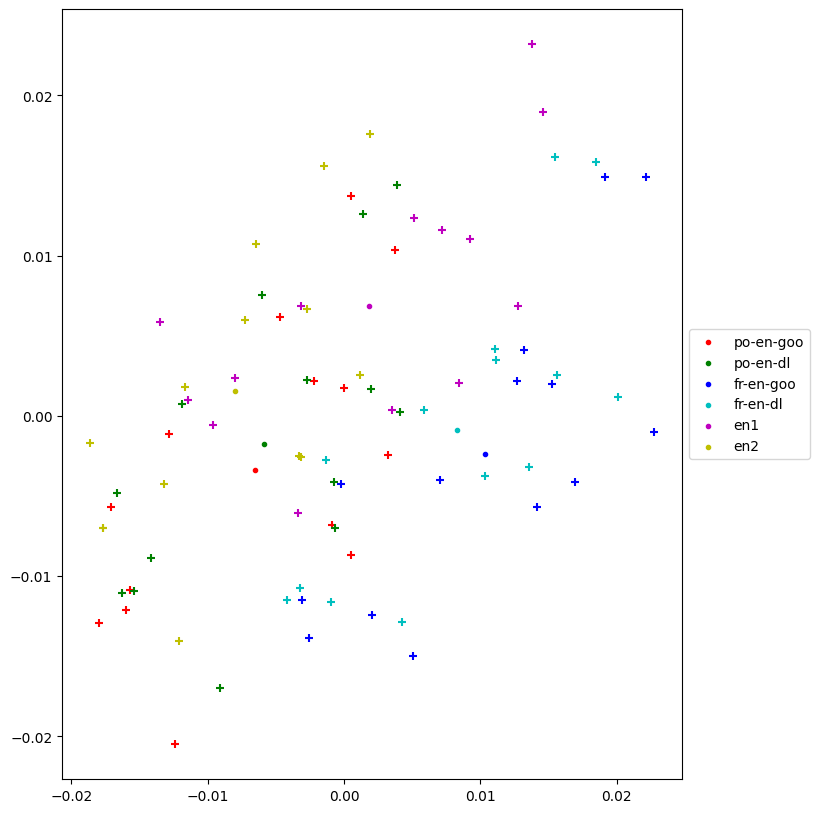

In [264]:
df6 = df2[top200]
df5 = df4[top200]
# Applies principal component analysis
pca = PCA(n_components=2)
pca_fnc_doc = pca.fit_transform(df5)
pca_fnc_chp = pca.transform(df6)

# Plat function words based on chapters and books
colours = ['r','g','b','c','m','y']
ax = plt.subplot(111)
for i in range(6):
    ax.scatter(pca_fnc_doc[i,0], pca_fnc_doc[i,1], color=colours[i], marker='.', label=BOOKS[i])
    ax.scatter(pca_fnc_chp[14*i:14*(i+1),0], pca_fnc_chp[14*i:14*(i+1),1], color=colours[i], marker='+')

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()